In [2]:
#pip uninstall keras
#pip install keras==2.6.0
#!pip install spacy==2.0.12


In [9]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from funcsigs import signature
from sklearn.metrics import average_precision_score



In [10]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [11]:
ROOT_DIR = '/'.join(os.getcwd().split('/')[:-1])
df = pd.read_csv(f'{ROOT_DIR}/data/3days/train.csv')

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

In [12]:
# Python3 code to demonstrate
# to extract words from string
# using regex() + string.punctuation
import re
import string
 
# initializing string 
test_string = "Geeksforgeeks,    is best @# Computer Science Portal.!!!"
 
# printing original string
print ("The original string is : " +  test_string)
 
# using regex() + string.punctuation
# to extract words from string
res = re.sub('['+string.punctuation+']', '', test_string).split()


The original string is : Geeksforgeeks,    is best @# Computer Science Portal.!!!


In [16]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['TEXT'])

In [19]:
def cleansing(text):
    return re.sub("[^A-Za-z']+", ' ', str(text)).lower()

In [22]:
df['TEXT'] = df['TEXT'].apply(cleansing)

In [26]:
sent = [row.split() for row in df['TEXT']]

Creates the relevant phrases from the list of sentences:

In [27]:
from gensim.models.phrases import Phrases, Phraser
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 16:06:34: collecting all words and their counts
INFO - 16:06:34: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:06:37: PROGRESS: at sentence #10000, processed 2853064 words and 540997 word types
INFO - 16:06:41: PROGRESS: at sentence #20000, processed 5719182 words and 793479 word types
INFO - 16:06:45: PROGRESS: at sentence #30000, processed 8584130 words and 977790 word types
INFO - 16:06:48: PROGRESS: at sentence #40000, processed 11437760 words and 1129356 word types
INFO - 16:06:51: collected 1232411 word types from a corpus of 13672551 words (unigram + bigrams) and 47793 sentences
INFO - 16:06:51: using 1232411 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:z


In [28]:
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 16:06:51: source_vocab length 1232411
INFO - 16:06:59: Phraser built with 7167 phrasegrams


#### Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of big

In [29]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

60201

In [30]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['and', 'the', 'to', 'of', 'with', 'no', 'for', 'in', 'is', 'on']

#### Training the model

In [31]:
import multiprocessing

from gensim.models import Word2Vec

In [32]:
cores = multiprocessing.cpu_count() # Count the number of cores in a compute

#### The parameters:
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [33]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

#### Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [34]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:07:22: collecting all words and their counts
INFO - 16:07:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:07:27: PROGRESS: at sentence #10000, processed 2428321 words, keeping 35373 word types
INFO - 16:07:32: PROGRESS: at sentence #20000, processed 4866590 words, keeping 44547 word types
INFO - 16:07:36: PROGRESS: at sentence #30000, processed 7304188 words, keeping 51111 word types
INFO - 16:07:41: PROGRESS: at sentence #40000, processed 9731895 words, keeping 56489 word types
INFO - 16:07:45: collected 60201 word types from a corpus of 11631964 raw words and 47793 sentences
INFO - 16:07:45: Loading a fresh vocabulary
INFO - 16:07:45: effective_min_count=20 retains 17517 unique words (29% of original 60201, drops 42684)
INFO - 16:07:45: effective_min_count=20 leaves 11481762 word corpus (98% of original 11631964, drops 150202)
INFO - 16:07:45: deleting the raw counts dictionary of 60201 items
INFO - 16:07:45: sample=6e-05 downsamples 952 most

Time to build vocab: 0.43 mins


#### Training of the model
Parameters of the training:

* total_examples = int - Count of sentences
* epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [35]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:07:48: training model with 71 workers on 17517 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 16:07:49: EPOCH 1 - PROGRESS: at 3.16% examples, 179895 words/s, in_qsize 0, out_qsize 0
INFO - 16:07:50: EPOCH 1 - PROGRESS: at 5.03% examples, 143619 words/s, in_qsize 0, out_qsize 0
INFO - 16:07:51: EPOCH 1 - PROGRESS: at 6.91% examples, 132494 words/s, in_qsize 0, out_qsize 0
INFO - 16:07:52: EPOCH 1 - PROGRESS: at 8.70% examples, 124213 words/s, in_qsize 6, out_qsize 0
INFO - 16:07:53: EPOCH 1 - PROGRESS: at 10.38% examples, 117879 words/s, in_qsize 29, out_qsize 1
INFO - 16:07:54: EPOCH 1 - PROGRESS: at 13.18% examples, 125412 words/s, in_qsize 41, out_qsize 0
INFO - 16:07:56: EPOCH 1 - PROGRESS: at 15.24% examples, 123293 words/s, in_qsize 61, out_qsize 1
INFO - 16:07:57: EPOCH 1 - PROGRESS: at 17.18% examples, 121782 words/s, in_qsize 80, out_qsize 0
INFO - 16:07:58: EPOCH 1 - PROGRESS: at 20.00% examples, 126175 words/s, in_qsize 96, ou

Time to train the model: 15.1 mins


In [38]:
pwd

'/home/x1112373/clinicalBERT/CS598-project/modeling'

In [39]:
w2v_model.save("clinical_word2vec_final.model")

INFO - 16:29:01: saving Word2Vec object under clinical_word2vec_final.model, separately None
INFO - 16:29:01: not storing attribute vectors_norm
INFO - 16:29:01: not storing attribute cum_table
INFO - 16:29:02: saved clinical_word2vec_final.model


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.similarity("brain", 'sepsis')

In [ ]:
w2v_model.wv.most_similar(positive=["brain"])

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

INFO - 16:29:09: precomputing L2-norms of word weight vectors


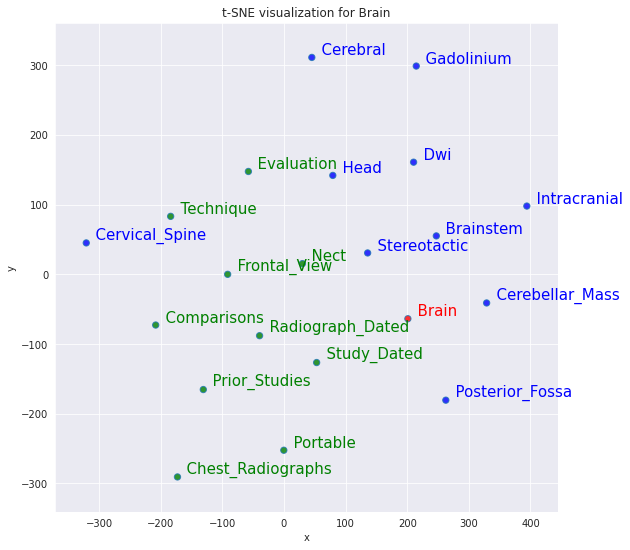

In [41]:
tsnescatterplot(w2v_model, "brain", [t[0] for t in w2v_model.wv.most_similar(positive=["examination"], topn=20)][10:])

In [42]:
%matplotlib inline

import gensim
m = gensim.models.KeyedVectors.load('clinical_word2vec_final.model')
weights = (m[m.wv.vocab])

INFO - 16:29:48: loading Word2VecKeyedVectors object from clinical_word2vec_final.model
INFO - 16:29:49: loading wv recursively from clinical_word2vec_final.model.wv.* with mmap=None
INFO - 16:29:49: setting ignored attribute vectors_norm to None
INFO - 16:29:49: loading vocabulary recursively from clinical_word2vec_final.model.vocabulary.* with mmap=None
INFO - 16:29:49: loading trainables recursively from clinical_word2vec_final.model.trainables.* with mmap=None
INFO - 16:29:49: setting ignored attribute cum_table to None
INFO - 16:29:49: loaded clinical_word2vec_final.model
/tmp/ipykernel_5741/3885060030.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  weights = (m[m.wv.vocab])


In [43]:

max_words_count = 44082
embedding_size = 300
max_words_length = 318

def plot_auc(x,y):
    y_pred = model.predict(x).ravel()
    y_pred_s = [1 if i else 0 for i in (y_pred >= 0.5)]
    print (sum(y_pred_s == y) / len(y))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Test (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return y_pred

def vote_score(df, score):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(x, temp.values)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Val (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print (auc_keras)
    return fpr_keras, tpr_keras


def vote_pr_curve(df, score):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    
    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
    vote_df = pd.DataFrame(data =  list(zip(temp, y)), columns = ['score','label'])
    
    pr_curve_plot(y, temp)
    
    return pr_thres, vote_df, precision, recall


def pr_curve_plot(y, y_score):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall,precision)
    print(area)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    average_precision1 = average_precision_score(y, y_score)
    print(average_precision1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
              area))

 
data_path = f'{ROOT_DIR}/data/3days/'
train_path = data_path+'train.csv'
val_path = data_path+'val.csv'
test_path = data_path+'test.csv'
df_train=pd.read_csv(train_path)
df_val=pd.read_csv(val_path)
df_test=pd.read_csv(test_path)
df_test2 = pd.read_csv(f'{ROOT_DIR}/data/2days/test.csv')

sent_train = df_train['TEXT']
y_train = df_train['Label']
sent_val = df_val['TEXT']
y_val = df_val['Label']
sent_test = df_test['TEXT']
y_test = df_test['Label']
sent_test2 = df_test2['TEXT']
y_test2 = df_test2['Label']

tokenizer=Tokenizer(num_words=max_words_count)
tokenizer.fit_on_texts(sent_train)
tokens_train = tokenizer.texts_to_sequences(sent_train)
tokens_val = tokenizer.texts_to_sequences(sent_val)
tokens_test = tokenizer.texts_to_sequences(sent_test)
tokens_test2 = tokenizer.texts_to_sequences(sent_test2)

x_train=pad_sequences(tokens_train,maxlen=max_words_length)
x_val=pad_sequences(tokens_val,maxlen = max_words_length)
x_test=pad_sequences(tokens_test,maxlen=max_words_length)
x_test2=pad_sequences(tokens_test2,maxlen=max_words_length)

word_idx=tokenizer.word_index
embed_dict = dict(zip(list(m.wv.vocab),list(m[m.wv.vocab])))
all_embs = np.stack(embed_dict.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_words_count, embedding_size))
for word,j in word_idx.items():
    if j < max_words_count:
        vec_temp=embed_dict.get(word)
        if vec_temp is not None:
            embedding_matrix[j]=vec_temp

inp=Input(shape=(max_words_length,))
x=Embedding(max_words_count,embedding_size,weights=[embedding_matrix])(inp)
x=Bidirectional(LSTM(embedding_size,return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x=GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae','accuracy'])
 
save_path = 'best_model_early_good.h5'
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)]

history = model.fit(x_train, y_train, batch_size=64, epochs=3, callbacks=callbacks, verbose=1, validation_data=(x_val, y_val))

/tmp/ipykernel_5741/283341699.py:106: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embed_dict = dict(zip(list(m.wv.vocab),list(m[m.wv.vocab])))
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


2022-04-29 16:30:12.419955: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 16:30:13.750279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2022-04-29 16:30:13.752166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30967 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
WARNING - 16:30:14: Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as 

WARNING - 16:30:14: Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


WARNING - 16:30:14: Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2022-04-29 16:30:14.799974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
747/747 [==============================] - 1409s 2s/step - loss: 0.6323 - mae: 0.4458 - accuracy: 0.6251 - val_loss: 0.7448 - val_mae: 0.4658 - val_accuracy: 0.5532
Epoch 2/3
747/747 [==============================] - 1382s 2s/step - loss: 0.4619 - mae: 0.3150 - accuracy: 0.7589 - val_loss: 0.9248 - val_mae: 0.4465 - val_accuracy: 0.5573
Epoch 3/3
747/747 [==============================] - 1380s 2s/step - loss: 0.3421 - mae: 0.2287 - accuracy: 0.8304 - val_loss: 1.0443 - val_mae: 0.4422 - val_accuracy: 0.5805


In [46]:
history.history

{'loss': [0.6323038935661316, 0.4619220495223999, 0.34211841225624084],
 'mae': [0.44583603739738464, 0.3150396943092346, 0.22868722677230835],
 'accuracy': [0.6251333951950073, 0.7589186429977417, 0.8303935527801514],
 'val_loss': [0.7448176741600037, 0.9247574806213379, 1.0443345308303833],
 'val_mae': [0.46577510237693787, 0.446450799703598, 0.44218307733535767],
 'val_accuracy': [0.5531693696975708, 0.5573259592056274, 0.5805334448814392]}

In [51]:
x_test_predict = model.predict(x_test)

In [52]:
x_test2_predict = model.predict(x_test2)

In [53]:
x_test_predict

array([[0.16287845],
       [0.6624203 ],
       [0.53539073],
       ...,
       [0.84530824],
       [0.11426383],
       [0.38463643]], dtype=float32)

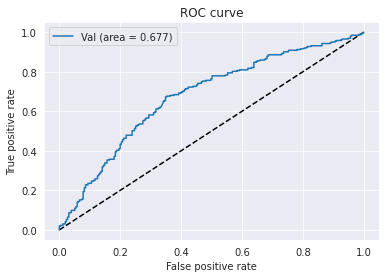

Recall at Precision of 80 is {} 0.022813688212927757


<Figure size 432x288 with 0 Axes>

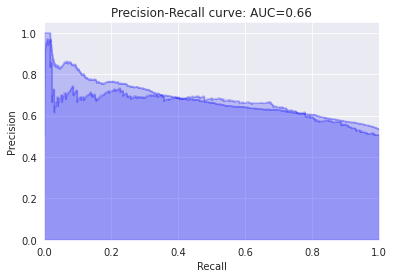

In [58]:
from modeling_utils import vote_score, pr_curve_plot, vote_pr_curve
%matplotlib inline
output_dir = f'{ROOT_DIR}/modeling/output2/'
fpr, tpr, df_out, roc_auc = vote_score(df_test, x_test_predict, output_dir)
pr_auc = pr_curve_plot(df_test['Label'].values, x_test_predict, output_dir)
rp80 =  vote_pr_curve(df_test, x_test_predict, output_dir)


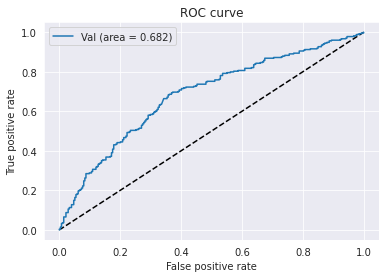

Recall at Precision of 80 is {} 0.08759124087591241


<Figure size 432x288 with 0 Axes>

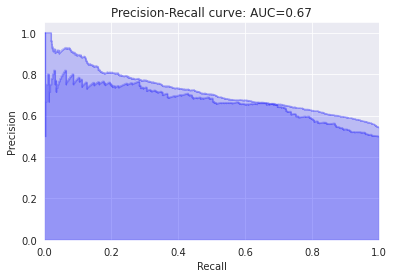

In [61]:
from modeling_utils import vote_score, pr_curve_plot, vote_pr_curve
%matplotlib inline
output_dir = f'{ROOT_DIR}/modeling/output2/'
fpr, tpr, df_out, roc_auc = vote_score(df_test2, x_test2_predict, output_dir)
pr_auc = pr_curve_plot(df_test2['Label'].values, x_test2_predict, output_dir)
rp80 =  vote_pr_curve(df_test2, x_test2_predict, output_dir)
